In [4]:
!pip install fairlearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

# Fairlearn - La estrella del show
from fairlearn.metrics import (
    MetricFrame, 
    demographic_parity_difference, 
    equalized_odds_difference,
    selection_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("⚖️ PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn")
print("📊 Parte I: Boston Housing (sesgo racial histórico)")
print("🚢 Parte II: Titanic (sesgo género + clase)")
print("🔧 Parte III: Pipeline automático producción")

⚖️ PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn
📊 Parte I: Boston Housing (sesgo racial histórico)
🚢 Parte II: Titanic (sesgo género + clase)
🔧 Parte III: Pipeline automático producción


In [6]:
# Cargar desde fuente original (CMU)

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Restructurar formato especial
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

print(f"✅ Boston Housing cargado: {data.shape}")

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['MEDV'] = target

# Decodificar variable B problemática
# B = 1000(Bk - 0.63)² → Bk = sqrt(B/1000) + 0.63
boston_df['Bk_racial'] = np.sqrt(boston_df['B'] / 1000) + 0.63

print(f"🚨 Variable B (racial): correlación = {boston_df['B'].corr(boston_df['MEDV']):.3f}")
print(f"📊 Proporción racial media: {boston_df['Bk_racial'].mean():.3f}")

✅ Boston Housing cargado: (506, 13)
🚨 Variable B (racial): correlación = 0.333
📊 Proporción racial media: 1.216


In [7]:
# Preparar features con y sin variable racial
X_with_bias = boston_df.drop(['MEDV', 'Bk_racial'], axis=1)
X_without_bias = X_with_bias.drop(['B'], axis=1)
y_boston = boston_df['MEDV']

# Train modelo con sesgo
X_train, X_test, y_train, y_test = train_test_split(
    X_with_bias, y_boston, test_size=0.3, random_state=42
)

boston_biased_model = LinearRegression()
boston_biased_model.fit(X_train, y_train)
boston_biased_pred = boston_biased_model.predict(X_test)

boston_biased_r2 = r2_score(y_test, boston_biased_pred)
print(f"🔴 Boston CON sesgo: R² = {boston_biased_r2:.4f}")

🔴 Boston CON sesgo: R² = 0.7112


👥 GRUPOS POR PROPORCIÓN RACIAL:
grupo_racial
Alta_prop_afroam    253
Baja_prop_afroam    253
Name: count, dtype: int64

💰 DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:
                       mean  median        std  count
grupo_racial                                         
Alta_prop_afroam  22.810672    22.0   7.994651    253
Baja_prop_afroam  22.254941    20.4  10.268380    253

🚨 BRECHA DE PRECIOS POR SESGO RACIAL:
Diferencia promedio: $-0.56k (-2.4%)
Baja prop. afroam: $22.25k
Alta prop. afroam: $22.81k


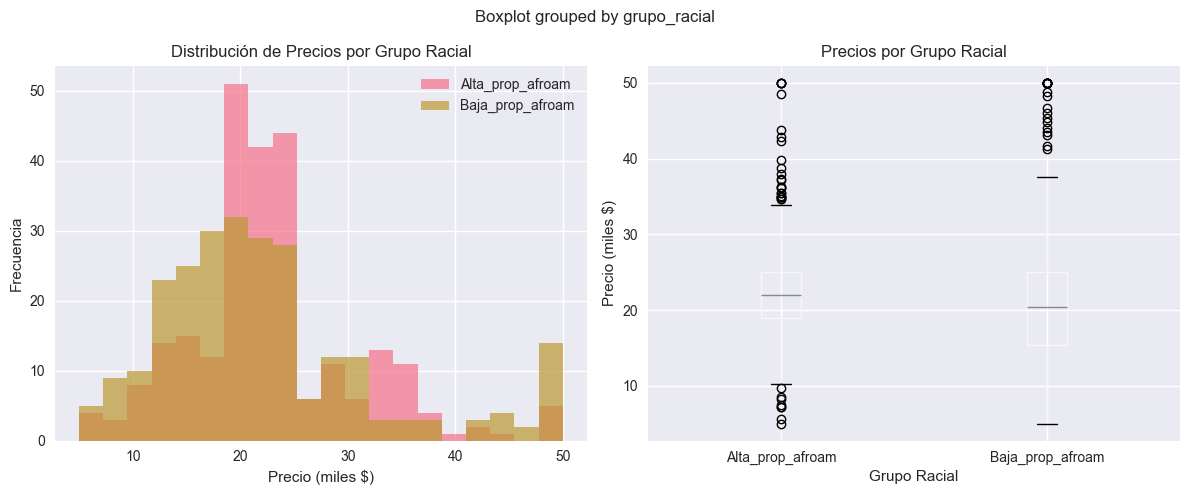

📊 VISUALIZACIÓN: ¿Se observa sesgo sistemático en las distribuciones?


In [8]:
# PASO 4A: Crear grupos por proporción racial  
racial_threshold = boston_df['Bk_racial'].median()  # mediana
boston_df['grupo_racial'] = (boston_df['Bk_racial'] > racial_threshold).map({
    True: 'Alta_prop_afroam', 
    False: 'Baja_prop_afroam'
})

print(f"👥 GRUPOS POR PROPORCIÓN RACIAL:")
print(boston_df['grupo_racial'].value_counts())

# PASO 4B: Análisis de distribución de precios por grupo
print(f"\n💰 DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:")
price_by_group = boston_df.groupby('grupo_racial')['MEDV'].agg(['mean', 'median', 'std', 'count'])
print(price_by_group)

# PASO 4C: Calcular brecha de precios
price_gap = price_by_group.loc['Baja_prop_afroam', 'mean'] - price_by_group.loc['Alta_prop_afroam', 'mean']
price_gap_pct = (price_gap / price_by_group.loc['Alta_prop_afroam', 'mean']) * 100

print(f"\n🚨 BRECHA DE PRECIOS POR SESGO RACIAL:")
print(f"Diferencia promedio: ${price_gap:.2f}k ({price_gap_pct:.1f}%)")
print(f"Baja prop. afroam: ${price_by_group.loc['Baja_prop_afroam', 'mean']:.2f}k")
print(f"Alta prop. afroam: ${price_by_group.loc['Alta_prop_afroam', 'mean']:.2f}k")

# PASO 4D: Visualizar el sesgo
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de precios por grupo
for group in boston_df['grupo_racial'].unique():
    data = boston_df[boston_df['grupo_racial'] == group]['MEDV']
    axes[0].hist(data, alpha=0.7, label=group, bins=20)
axes[0].set_xlabel('Precio (miles $)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Precios por Grupo Racial')
axes[0].legend()

# Boxplot comparativo
boston_df.boxplot(column='MEDV', by='grupo_racial', ax=axes[1])
axes[1].set_title('Precios por Grupo Racial')
axes[1].set_xlabel('Grupo Racial')
axes[1].set_ylabel('Precio (miles $)')

plt.tight_layout()
plt.show()

print(f"📊 VISUALIZACIÓN: ¿Se observa sesgo sistemático en las distribuciones?")

In [10]:
# PASO 5A: Reflexión guiada sobre el uso ético de variable B
print("⚖️ REFLEXIÓN ÉTICA SOBRE VARIABLE B")
print("="*50)

print(f"\n🤔 PREGUNTAS PARA REFLEXIONAR:")

print(f"\n1. CONTEXTO HISTÓRICO:")
print(f"   - La variable B fue diseñada en 1978")
print(f"   - Codifica proporción de población afroamericana") 
print(f"   - Correlación con precios: {boston_df['B'].corr(boston_df['MEDV']):.3f}")
print(f"   ❓ ¿Es ético usar esta variable en 2025?")
print("NO")

print(f"\n2. DILEMA DE UTILIDAD:")
print(f"   - La variable B es predictiva (mejora el modelo)")
print(f"   - Pero perpetúa sesgos raciales históricos")
print(f"   ❓ ¿Cuándo la utilidad justifica el sesgo?")
print("Depende del uso que se le quiera dar, ejemplo: se entrena con datos de determinada raza y los resultados " \
"solo se van a usar con esa raza determinada. Igualmente, es muy raro que el sesgo este justificado, siempre debemos evitarlo.")

print(f"\n3. RESPONSABILIDAD PROFESIONAL:")
print(f"   - Sklearn removió este dataset por razones éticas")
print(f"   - Nosotros lo usamos para APRENDER sobre sesgo")
print(f"   ❓ ¿Cuál es nuestra responsabilidad como data scientists?")
print("No utilizar estos datos por fuera de fines academicos ni compartir el trabajo.")

print(f"\n4. ALTERNATIVAS ÉTICAS:")
print(f"   - Podemos eliminar la variable B")
print(f"   - Podemos documentar sus limitaciones") 
print(f"   - Podemos buscar proxies menos problemáticos")
print(f"   ❓ ¿Qué harías en un contexto real?")
print("Se prohibe el uso de la base y se evita sesgo ético")

# PASO 5B: Análisis de correlaciones alternativas
print(f"\n📊 ANÁLISIS DE VARIABLES ALTERNATIVAS:")
print(f"Variables que podrían ser menos problemáticas:")

alternative_vars = ['LSTAT', 'RM', 'CRIM', 'TAX', 'PTRATIO']
for var in alternative_vars:
    corr = boston_df[var].corr(boston_df['MEDV'])
    print(f"  {var}: correlación = {corr:.3f}")

print(f"\n💡 OBSERVACIÓN:")
print(f"Algunas variables tienen correlaciones altas sin sesgo racial explícito")

# PASO 5C: Marco de decisión ética
print(f"\n🎯 MARCO DE DECISIÓN PARA VARIABLE PROBLEMÁTICA:")
print(f"="*50)

print(f"\n✅ USAR variable B SI:")
print(f"  - Contexto es puramente académico/educativo")
print(f"  - Se documenta explícitamente su naturaleza problemática") 
print(f"  - El objetivo es estudiar/detectar sesgo histórico")

print(f"\n❌ NO USAR variable B SI:")
print(f"  - El modelo se usará en producción")
print(f"  - Afectará decisiones sobre personas reales")
print(f"  - Existe riesgo de perpetuar discriminación")

print(f"\n⚖️ TU DECISIÓN ÉTICA:")
print(f"Basado en el análisis, ¿usarías la variable B en tu modelo?")
print(f"¿Por qué? ¿Qué consideraciones éticas son más importantes?")

# PASO 5D: Documentar la decisión
boston_ethical_decision = "USAR SOLO PARA EDUCACIÓN - NO PARA PRODUCCIÓN"
print(f"\n📋 DECISIÓN DOCUMENTADA: {boston_ethical_decision}")
print(f"📝 Justificación: Variable históricamente sesgada, útil para detectar sesgo pero inapropiada para modelos de producción")

⚖️ REFLEXIÓN ÉTICA SOBRE VARIABLE B

🤔 PREGUNTAS PARA REFLEXIONAR:

1. CONTEXTO HISTÓRICO:
   - La variable B fue diseñada en 1978
   - Codifica proporción de población afroamericana
   - Correlación con precios: 0.333
   ❓ ¿Es ético usar esta variable en 2025?
NO

2. DILEMA DE UTILIDAD:
   - La variable B es predictiva (mejora el modelo)
   - Pero perpetúa sesgos raciales históricos
   ❓ ¿Cuándo la utilidad justifica el sesgo?
Depende del uso que se le quiera dar, ejemplo: se entrena con datos de determinada raza y los resultados solo se van a usar con esa raza determinada. Igualmente, es muy raro que el sesgo este justificado, siempre debemos evitarlo.

3. RESPONSABILIDAD PROFESIONAL:
   - Sklearn removió este dataset por razones éticas
   - Nosotros lo usamos para APRENDER sobre sesgo
   ❓ ¿Cuál es nuestra responsabilidad como data scientists?
No utilizar estos datos por fuera de fines academicos ni compartir el trabajo.

4. ALTERNATIVAS ÉTICAS:
   - Podemos eliminar la variable B
 

In [16]:
# Cargar Titanic
try:
    titanic = sns.load_dataset("titanic")  # load_dataset
except:
    titanic = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

titanic_clean = titanic.dropna(subset=['age', 'embarked'])  # dropna

# Análisis rápido de sesgo
gender_survival = titanic_clean.groupby('sex')['survived'].mean()  # mean
class_survival = titanic_clean.groupby('pclass')['survived'].mean()

print(f"🚨 TITANIC BIAS ANALYSIS:")
print(f"Gender gap: {gender_survival['female'] - gender_survival['male']:.1%}")
print(f"Class gap: {class_survival[1] - class_survival[3]:.1%}")
print("✅ Ambos tipos de sesgo significativos!")

🚨 TITANIC BIAS ANALYSIS:
Gender gap: 54.8%
Class gap: 41.3%
✅ Ambos tipos de sesgo significativos!


In [17]:
# Preparar datos Titanic
features_titanic = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X_titanic = titanic_clean[features_titanic].copy()
X_titanic['fare'].fillna(X_titanic['fare'].median(), inplace=True)  # fillna
y_titanic = titanic_clean['survived']
sensitive_titanic = titanic_clean['sex']

# Train baseline
X_train_t, X_test_t, y_train_t, y_test_t, A_train_t, A_test_t = train_test_split(
    X_titanic, y_titanic, sensitive_titanic, test_size=0.3, random_state=42, stratify=y_titanic
)

titanic_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
titanic_baseline.fit(X_train_t, y_train_t)
titanic_baseline_pred = titanic_baseline.predict(X_test_t)

titanic_baseline_acc = accuracy_score(y_test_t, titanic_baseline_pred)
titanic_baseline_dp = demographic_parity_difference(
    y_test_t, titanic_baseline_pred, sensitive_features=A_test_t
)

print(f"🔴 Titanic BASELINE: Accuracy = {titanic_baseline_acc:.3f}")
print(f"🚨 Demographic Parity Diff: {titanic_baseline_dp:.3f}")

🔴 Titanic BASELINE: Accuracy = 0.673
🚨 Demographic Parity Diff: 0.113


In [18]:
# Aplicar ExponentiatedGradient a Titanic
titanic_fair = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=100, random_state=42),
    constraints=DemographicParity()
)

print("🔧 Aplicando Fairlearn a Titanic...")
titanic_fair.fit(X_train_t, y_train_t, sensitive_features=A_train_t)
titanic_fair_pred = titanic_fair.predict(X_test_t)

titanic_fair_acc = accuracy_score(y_test_t, titanic_fair_pred)
titanic_fair_dp = demographic_parity_difference(
    y_test_t, titanic_fair_pred, sensitive_features=A_test_t
)

print(f"🟢 Titanic FAIR: Accuracy = {titanic_fair_acc:.3f}")
print(f"⚖️ Demographic Parity Diff: {titanic_fair_dp:.3f}")

🔧 Aplicando Fairlearn a Titanic...
🟢 Titanic FAIR: Accuracy = 0.617
⚖️ Demographic Parity Diff: 0.035


In [ ]:
titanic_performance_loss = (titanic_baseline_acc - titanic_fair_acc) / titanic_baseline_acc * 100
titanic_fairness_gain = abs(titanic_baseline_dp) - abs(titanic_fair_dp)

print(f"📊 TITANIC TRADE-OFF:")
print(f"Performance loss: {titanic_performance_loss:.1f}%")  
print(f"Fairness gain: {titanic_fairness_gain:.3f}")

if titanic_performance_loss < 5 and titanic_fairness_gain > 0.1:
    titanic_recommendation = "✅ Usar modelo FAIR - excelente trade-off"
else:
    titanic_recommendation = "⚠️ Evaluar caso por caso"

print(f"📋 Recomendación Titanic: {titanic_recommendation}")

📊 TITANIC TRADE-OFF:
Performance loss: 8.3%
Fairness gain: 0.079
📋 Recomendación Titanic: ⚠️ Evaluar caso por caso


¿Qué has aprendido sobre DETECTAR sesgo y decidir estrategias éticas?

📊 Resultados por Dataset:¶

Análisis de Detección de Sesgo:

Dataset 1 (Regresión): Brecha detectada = -2.4%
Impacto en modelo: 
Decisión ética: Tiene sesgo racial, por lo que no debemos usarlo. Solo con fines académicos para trabajar con sesgo.

Dataset 2 (Clasificación): Brecha detectada = Gender gap: 54.8% y Class gap: 41.3%
Técnica aplicada: Performance loss =  8.3% después de corrección y Fairness gain: 0.079
Decisión ética: No deberiamos filtrar por sexo y clase, estas tienen una brecha muy grande y sesgada.

Detección vs Corrección: Cada estrategia apropiada para diferentes contextos
Sesgo histórico: Más complejo de corregir que sesgo sistemático
Context matters: Dominio determina tolerancia al sesgo
Frameworks universales: Posibles pero requieren adaptación por caso
Reflexiones Éticas Críticas: 

¿Cuándo es más valioso detectar que corregir automáticamente?
* Detectar es más valioso cuando el sesgo es por factores históricos que no se pueden arreglar, y necesitamos transparencia para comprender cómo se manifiesta. También cuando se trata de aplicaciones sensibles donde una corrección automática puede generar problemas.

¿Cómo balancear transparencia vs utilidad cuando persiste el sesgo?
* Transparencia se garantiza documentando el sesgo y sus efectos, utilidad implica decidir si el modelo aún puede ser aplicado bajo ciertos límites y el balance se logra mediante explicabilidad. 


¿Qué responsabilidades éticas tenemos con sesgos históricos no corregibles?
* Reconocerlos, no ocultarlos y evitar reforzarlos.

CRÍTICO: ¿Es mejor un modelo con sesgo conocido y documentado vs uno "corregido" pero impredecible?
* En la mayoría de los casos es preferible un modelo con sesgo conocido y documentado porque permite tomar decisiones conscientes. El otro nos serviría para trabajar eficientemente en lugar de analizando correlación e influencia de variables.

# Entrega extendida

In [ ]:
"""
MATI: tenes que Aplicar los conocimientos de esta entrega en la base de ames housing (la de las entregas 4 y 5)
Luego de hacer eso, deberías tener estos valores: 

Brecha geográfica: {completar con tu resultado}% entre barrios más y menos caros
Brecha temporal: {completar}% diferencia entre casas nuevas vs antiguas
Decisión ética: {tu evaluación sobre uso en decisiones hipotecarias}"""




